In Random Forest Model

Make comparison of RMSE estimation for two different set of bins and for dataframe with and without imbued 0s.

***Note: the highly correlated features in dataset without imbued 0s are different(only two features with correlation value greater than 10).***

In [1]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib

wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")
#display(combined_input_data)

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value
#combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 


combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)

features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        #'GEN_Bu_p_inSSA', 
        #'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']


df=combined_input_data.dropna()
display(df)





,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568
10,durian2006,137.825000,11.141667,5.282292,45.946435,96996.365877,58.003453,0.00,0.00,0.00,...,0.408163,0.208617,3.247166,0.045351,0.018141,0.036281,0.199546,0.470131,6.820862,0.272109
33,durian2006,153.995000,14.470833,6.238125,23.682962,13283.363247,103.825021,3.10,3.37,3.37,...,0.076296,2.153882,36.968132,0.064558,0.000000,0.093902,0.023476,1.983335,35.007923,0.011738
36,durian2006,184.885714,12.269048,6.526786,48.395610,113349.056134,47.016707,2.98,3.48,3.48,...,0.443766,1.248093,11.537928,0.284288,0.055471,0.152545,0.159479,1.114579,13.992511,0.000000
37,durian2006,187.387500,12.754167,6.935417,69.095429,329873.894253,3.822421,0.00,0.05,0.05,...,0.184372,3.107989,21.852502,0.166813,0.017559,0.052678,0.210711,2.142772,24.416155,1.053556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25382,meranti2016,297.450000,20.550000,11.245833,60.682289,223452.827181,36.716509,9.05,0.90,0.90,...,0.000000,7.062147,0.282486,0.000000,0.000000,0.000000,0.000000,0.771010,16.384181,1.412429
25572,noul2015,169.225000,18.904167,7.112766,54.379415,160806.495664,13.322384,10.98,0.00,0.00,...,0.000000,7.563025,0.560224,0.000000,0.000000,0.000000,0.000000,0.226074,16.246499,0.000000
25773,noul2015,113.950000,9.426852,4.442080,63.460137,255565.964794,9.357787,1.44,18.88,18.80,...,0.181277,0.828694,10.630584,0.064742,0.025897,0.116535,0.090638,1.154805,13.259096,0.634468
25786,noul2015,84.687500,6.039583,3.543085,38.632415,57657.470633,54.779271,2.31,15.20,15.20,...,0.093414,0.677254,6.632415,0.023354,0.070061,0.046707,0.046707,1.187099,11.560019,0.070061


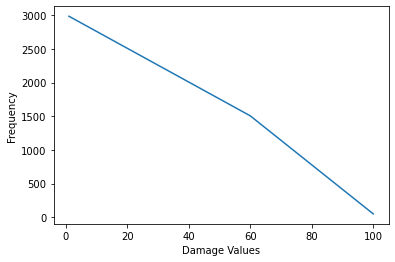

In [2]:
#The Old and New set of bins
bins2= [0, 1, 60, 100]
#bins2 = [0, 0.00009, 1, 10, 50, 100]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [3]:
print(samples_per_bin2)
print(binsP2)

[2985 1506   50]
[  0   1  60 100]


In [4]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [5]:
y_input_strat=bin_index2

In [6]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-10-20 03:09:20


In [7]:
#Define empty lists for bins results(test)
test_MAE_list_bin1=[]
test_MAE_list_bin2=[]
test_MAE_list_bin3=[]
test_MAE_list_bin4=[]

test_RMSE_list_bin1=[]
test_RMSE_list_bin2=[]
test_RMSE_list_bin3=[]
test_RMSE_list_bin4=[]

#Define empty lists for bins results(train)
train_MAE_list_bin1=[]
train_MAE_list_bin2=[]
train_MAE_list_bin3=[]
train_MAE_list_bin4=[]

train_RMSE_list_bin1=[]
train_RMSE_list_bin2=[]
train_RMSE_list_bin3=[]
train_RMSE_list_bin4=[]

In [8]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statistics
# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


for i in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    
    bin_index_test=np.digitize(y_test, bins=binsP2)
    bin_index_train=np.digitize(y_train, bins=binsP2)
    
    #With Solving Overfitting
    #rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5, max_samples=0.7)
    
    #Without Solving Overfitting
    rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)
    
    rf_model=rf.fit(X_train, y_train)
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())
    
    y_pred_train = rf.predict(X_train)
    mae_train_idx1 = mean_absolute_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    mae_train_idx2 = mean_absolute_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    mae_train_idx3 = mean_absolute_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    mae_train_idx4 = mean_absolute_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
    
    
    mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    rmse_train_3 = np.sqrt(mse_train_idx3)
    mse_train_idx4 = mean_squared_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
    rmse_train_4 = np.sqrt(mse_train_idx4)
    


    y_pred = rf.predict(X_test)
    mae_idx1 = mean_absolute_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    mae_idx2 = mean_absolute_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    mae_idx3 = mean_absolute_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    mae_idx4 = mean_absolute_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
    

    mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    rmse_1 = np.sqrt(mse_idx1)
    mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    rmse_2 = np.sqrt(mse_idx2)
    mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    rmse_3 = np.sqrt(mse_idx3)
    mse_idx4 = mean_squared_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
    rmse_4 = np.sqrt(mse_idx4)
    
    
    print('----- Training_bins_MAE  ------')
    print(f'Mean absolute error of bins_1: {mae_train_idx1:.2f}')
    print(f'Mean absolute error of bins_2: {mae_train_idx2:.2f}')
    print(f'Mean absolute error of bins_3: {mae_train_idx3:.2f}')
    print(f'Mean absolute error of bins_4: {mae_train_idx4:.2f}')
    
    print('----- Training_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_train_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_train_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_train_3:.2f}')
    print(f'Root mean squared error of bins_4: {rmse_train_4:.2f}')
    
    
    train_MAE_list_bin1.append(mae_train_idx1)
    train_MAE_list_bin2.append(mae_train_idx2)
    train_MAE_list_bin3.append(mae_train_idx3)
    train_MAE_list_bin4.append(mae_train_idx4)
    
    train_RMSE_list_bin1.append(rmse_train_1)
    train_RMSE_list_bin2.append(rmse_train_2)
    train_RMSE_list_bin3.append(rmse_train_3)
    train_RMSE_list_bin4.append(rmse_train_4)
    
    
    print('----- Test_bins_MAE  ------')
    print(f'Mean absolute error of bins_1: {mae_idx1:.2f}')
    print(f'Mean absolute error of bins_2: {mae_idx2:.2f}')
    print(f'Mean absolute error of bins_3: {mae_idx3:.2f}')
    print(f'Mean absolute error of bins_4: {mae_idx4:.2f}')
    
    print('----- Test_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_3:.2f}')
    print(f'Root mean squared error of bins_4: {rmse_4:.2f}')
    
    test_MAE_list_bin1.append(mae_idx1)
    test_MAE_list_bin2.append(mae_idx2)
    test_MAE_list_bin3.append(mae_idx3)
    test_MAE_list_bin4.append(mae_idx4)
    
    test_RMSE_list_bin1.append(rmse_1)
    test_RMSE_list_bin2.append(rmse_2)
    test_RMSE_list_bin3.append(rmse_3)
    test_RMSE_list_bin4.append(rmse_4)
    

print("***MAE Training Results***")   
print(train_MAE_list_bin1)    
print(train_MAE_list_bin2) 
print(train_MAE_list_bin3)    
print(train_MAE_list_bin4) 

print("***RMSE Training Results***")   
print(train_RMSE_list_bin1)    
print(train_RMSE_list_bin2) 
print(train_RMSE_list_bin3)    
print(train_RMSE_list_bin4)


print("***MAE Test Results***")   
print(test_MAE_list_bin1)    
print(test_MAE_list_bin2) 
print(test_MAE_list_bin3)    
print(test_MAE_list_bin4) 

print("***RMSE Test Results***")   
print(test_RMSE_list_bin1)    
print(test_RMSE_list_bin2) 
print(test_RMSE_list_bin3)    
print(test_RMSE_list_bin4)
    
    

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_RED_per_SSAbldg', 'GEN_OR_per_SSAbldg',
       'GEN_Yellow_per_LSbl', 'TOP_mean_slope', 'TOP_mean_elevation_m',
       'TOP_ruggedness_stdev', 'TOP_mean_ruggedness', 'TOP_slope_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     92.73
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        03:09:26   Log-Likelihood:                -13037.
No. Observations:                3632   AIC:                         2.614e+04
Df Residuals:                    3597   BIC:                         2.636e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3751      0.146     29.911      0.0

In [9]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-10-20 03:11:11


stdev_RMSE_test: 0.26
stdev_RMSE_train: 0.08
mean_RMSE_test: 2.59
mean_RMSE_train: 1.67


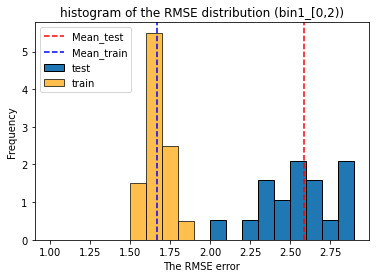

In [10]:
#RMSE of bins_1

m_test_rmse = statistics.mean(test_RMSE_list_bin1)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin1, bins=np.arange(1.0,3.0,0.1), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin1)


m_train_rmse = statistics.mean(train_RMSE_list_bin1)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin1, bins=np.arange(1.0,3.0,0.1), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(0.8,2.9,0.12)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin1)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin1_[0,2))')
plt.show()

stdev_RMSE_test: 0.77
stdev_RMSE_train: 0.15
mean_RMSE_test: 10.17
mean_RMSE_train: 6.66


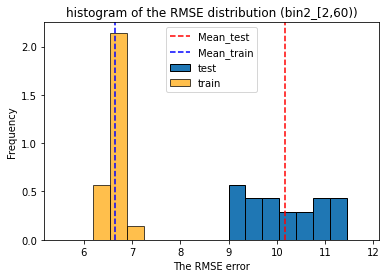

In [11]:
#RMSE of bins_2

m_test_rmse = statistics.mean(test_RMSE_list_bin2)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin2, bins=np.arange(5.5,12.0,0.35), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin2)


m_train_rmse = statistics.mean(train_RMSE_list_bin2)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin2, bins=np.arange(5.5,12.0,0.35), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(6.0,11.0,0.25)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin2)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin2_[2,60))')
plt.show()

stdev_RMSE_test: 6.06
stdev_RMSE_train: 1.52
mean_RMSE_test: 44.02
mean_RMSE_train: 33.29


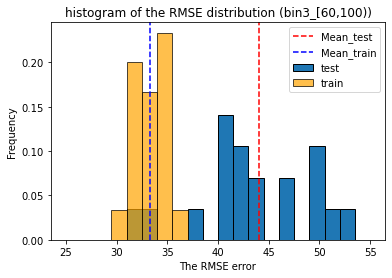

In [12]:
#RMSE of bins_3

m_test_rmse = statistics.mean(test_RMSE_list_bin3)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin3, bins=np.arange(25.0,56.0,1.5), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin3)


m_train_rmse = statistics.mean(train_RMSE_list_bin3)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin3, bins=np.arange(25.0,56.0,1.5), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin3)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin3_[60,100))')
plt.show()

stdev_RMSE_test: 4.36
stdev_RMSE_train: 4.42
mean_RMSE_test: 45.85
mean_RMSE_train: 39.18


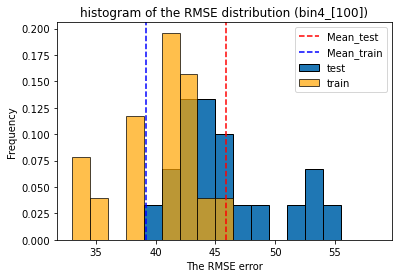

In [13]:
#RMSE of bins_4

m_test_rmse = statistics.mean(test_RMSE_list_bin4)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin4, bins=np.arange(33.0,60.0,1.5), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin4)


m_train_rmse = statistics.mean(train_RMSE_list_bin4)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin4, bins=np.arange(33.0,60.0,1.5), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(40.0,50.0,0.55)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin4)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin4_[100])')
plt.show()

In [14]:
X

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Red_per_LSbldg,GEN_Or_per_LSblg,...,VUL_StrongRoof_LightWall,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary
0,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,1.17,0.03,...,8.211552,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106
10,137.825000,11.141667,5.282292,45.946435,96996.365877,58.003453,0.00,0.00,0.00,0.00,...,12.426304,0.408163,0.208617,3.247166,0.045351,0.018141,0.036281,0.199546,0.470131,6.820862
33,153.995000,14.470833,6.238125,23.682962,13283.363247,103.825021,3.10,3.37,0.27,0.02,...,21.345149,0.076296,2.153882,36.968132,0.064558,0.000000,0.093902,0.023476,1.983335,35.007923
36,184.885714,12.269048,6.526786,48.395610,113349.056134,47.016707,2.98,3.48,0.37,0.00,...,16.876993,0.443766,1.248093,11.537928,0.284288,0.055471,0.152545,0.159479,1.114579,13.992511
37,187.387500,12.754167,6.935417,69.095429,329873.894253,3.822421,0.00,0.05,0.00,0.00,...,12.502195,0.184372,3.107989,21.852502,0.166813,0.017559,0.052678,0.210711,2.142772,24.416155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25382,297.450000,20.550000,11.245833,60.682289,223452.827181,36.716509,9.05,0.90,2.71,0.00,...,0.000000,0.000000,7.062147,0.282486,0.000000,0.000000,0.000000,0.000000,0.771010,16.384181
25572,169.225000,18.904167,7.112766,54.379415,160806.495664,13.322384,10.98,0.00,0.00,0.00,...,0.000000,0.000000,7.563025,0.560224,0.000000,0.000000,0.000000,0.000000,0.226074,16.246499
25773,113.950000,9.426852,4.442080,63.460137,255565.964794,9.357787,1.44,18.88,0.08,0.00,...,16.716302,0.181277,0.828694,10.630584,0.064742,0.025897,0.116535,0.090638,1.154805,13.259096
25786,84.687500,6.039583,3.543085,38.632415,57657.470633,54.779271,2.31,15.20,0.00,0.00,...,15.670248,0.093414,0.677254,6.632415,0.023354,0.070061,0.046707,0.046707,1.187099,11.560019
